In [ ]:
"""
 - get probability matrix
 - calculate randomwalk, wasserstein, symmetric KL, jaccard sp
 - plot results along with jaccard-shortest
"""

In [1]:
from scipy.io import loadmat
from scipy.sparse import find
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance, entropy
import numpy as np
import numpy.linalg as lalg
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [ ]:
# wrangle karate club data

mat = loadmat('karate.mat')
S = mat['Problem'][0][0][2]
G = nx.Graph(S)

mr_hi = set([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22])
split = {}
cols = {}
for i in G.nodes:
    split[i] = 0 if i+1 in mr_hi else 1
    cols[i] = 'red' if i+1 in mr_hi else 'black'
nx.set_node_attributes(G, split, 'cluster')
nx.set_node_attributes(G, cols, 'color')

In [2]:
# wrangle american football data (fixed by Tim Evans)

mat = loadmat('football_fixed.mat')
I,J = mat['links']
G = nx.Graph()
G.add_edges_from(zip(I,J))

confs = {}
cols = {}
cmap = plt.get_cmap('tab20')
for node in mat['nodes']:
    idx = int(node[0])
    conf = int(node[2])
    assert idx not in confs.keys()
    confs[idx] = conf
    cols[idx] = 'black' if conf > 10 else cmap(conf/11)
nx.set_node_attributes(G, confs, 'cluster')
nx.set_node_attributes(G, cols, 'color')

In [10]:
# wrangle caltech social network data

mat = loadmat('Caltech36.mat')
G = nx.Graph(mat['A'])

houses = {}
cols = {}
cmap = plt.get_cmap('tab10')
for i,x in enumerate(mat['local_info']):
    house = x[4]
    houses[i] = house
    cols[i] = 'black' if house==0 else cmap((house-165)/10)
nx.set_node_attributes(G, houses, 'cluster')
nx.set_node_attributes(G, cols, 'color')

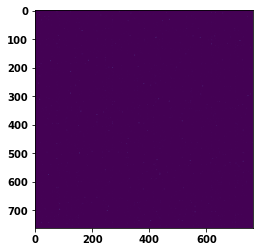

In [11]:
# get largest connected component and markov matrix

G = G.subgraph(max(nx.connected_components(G), key=len))
G = nx.relabel.convert_node_labels_to_integers(G, label_attribute='orig')

n = len(G)
A = nx.to_numpy_array(G)
   
for i in range(n):
    for j in range(i+1,n):
        assert A[i,j]==A[j,i]
        
D = np.identity(n, dtype=A.dtype) * np.sum(A, axis=1)
P = lalg.inv(D) @ A
plt.imshow(P)

In [12]:
def is_metric(dist):
    square = squareform(dist)
    n,m = square.shape
    assert n==m
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if square[i,j] > square[i,k]+square[k,j]:
                    return False
    return True

def draw(dist):
    Z = linkage(dist, method='ward', optimal_ordering=True)
    plt.figure(figsize=(20,5))
    plt.rcParams["font.weight"] = "bold"
    dend = dendrogram(Z, leaf_rotation=90, leaf_font_size=8)

def label(nx_graph):
    ticks, labels = plt.xticks()
    for label in labels:
        idx = int(label.get_text())
        label.set_color(nx_graph.nodes[idx]['color'])
    plt.xticks(ticks, labels)

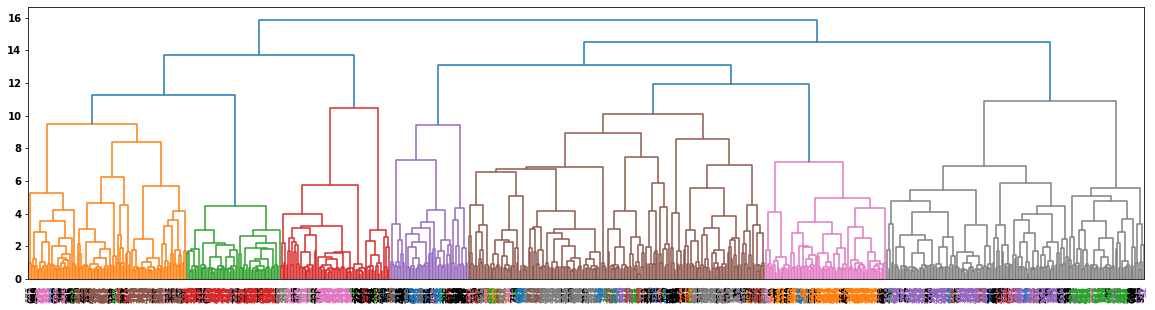

In [13]:
# jaccard shortest paths

jacc = pdist(A, metric='jaccard')
bacon = dijkstra(A, directed=False, unweighted=True)
dist = jacc * squareform(bacon)

# print(is_metric(dist))
draw(dist)
label(G)

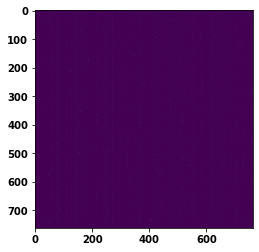

In [14]:
def embed(markov, factor, steps):
    '''weights each markov chain state according to a damping factor'''
    state = np.array(markov)
    final = np.array(markov)
    totaldamp = 1
    currdamp = factor
    for i in range(1,steps):
        state = state @ markov
        final += currdamp * state
        totaldamp += currdamp
        currdamp *= factor
    final /= totaldamp
    return final

steps = int(bacon.max())
Ppow = embed(P, .85, steps)
# Ppow = lalg.inv(sqrtm(D)) @ lalg.matrix_power(P, 2)
plt.imshow(Ppow)

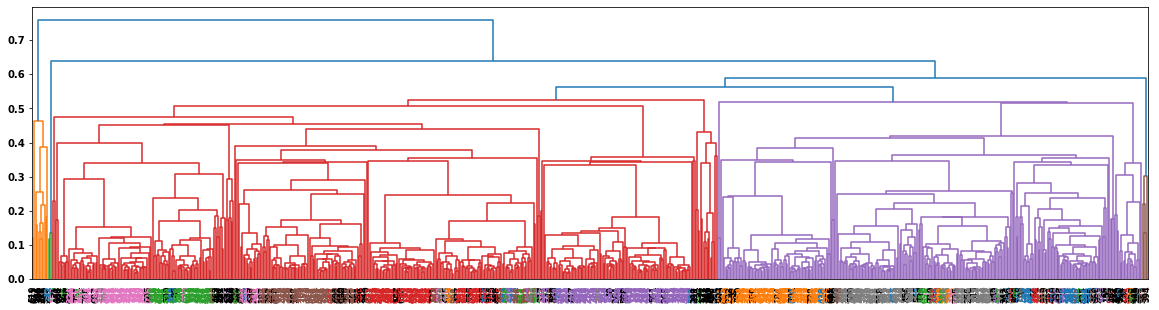

In [15]:
# cluster walktrap distance

dist = pdist(Ppow, metric='euclidean')
# print(is_metric(dist))
draw(dist)
label(G)

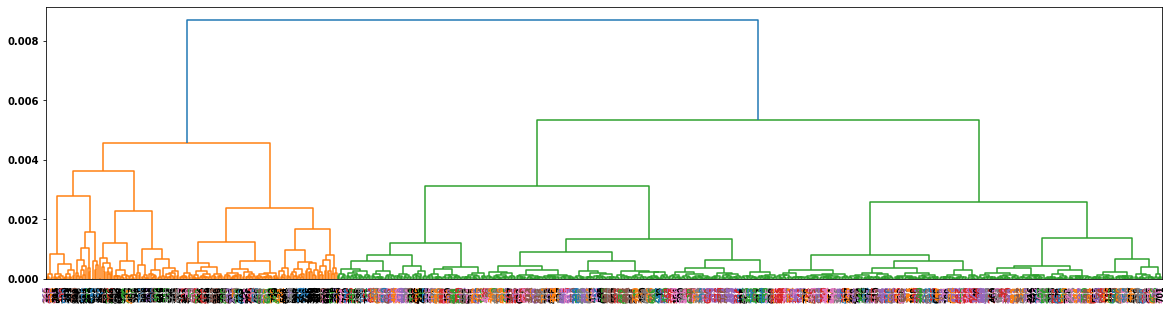

In [16]:
# wasserstein distance

dist = pdist(Ppow, wasserstein_distance)
# print(is_metric(squareform(dist), 1e-10))
draw(dist)
label(G)

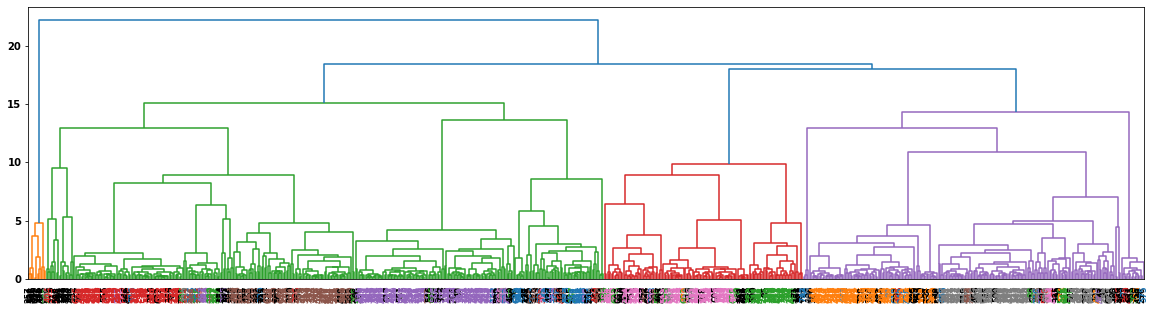

In [17]:
# symmetric KL

dist = pdist(Ppow, metric=lambda x,y: entropy(x,y)+entropy(y,x))
# print(is_metric(dist))
draw(dist)
label(G)

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))